# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Imported Python Libraries and Packages

In [87]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage import transform as skimage_transform
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from os import listdir
import csv
from scipy.ndimage import rotate

%matplotlib inline

---
## Step 0: Load The Data

In [88]:
### Load pickled data

training_file = 'dataset/train.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [89]:
### Load traffic sign labels
def load_traffic_sign_labels():
    result = []
    with open('signnames.csv', 'r') as csv_file:
        sign_names = csv.reader(csv_file, delimiter=',')
        next(sign_names, None)
        for row in sign_names:
            result.append(row[1])
        csv_file.close()
    return result

sign_labels = load_traffic_sign_labels()

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [90]:
### Replace each question mark with the appropriate value.

""" Global Variables """
n_train = len(y_train)
n_test = len(y_test)
image_shape = X_train.shape
_, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH = image_shape
n_classes = len(set(y_train))
GRAY_IMG_DEPTH = 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print('Image height: {}, width: {}'.format(IMG_HEIGHT, IMG_WIDTH))
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Image height: 32, width: 32
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [91]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.

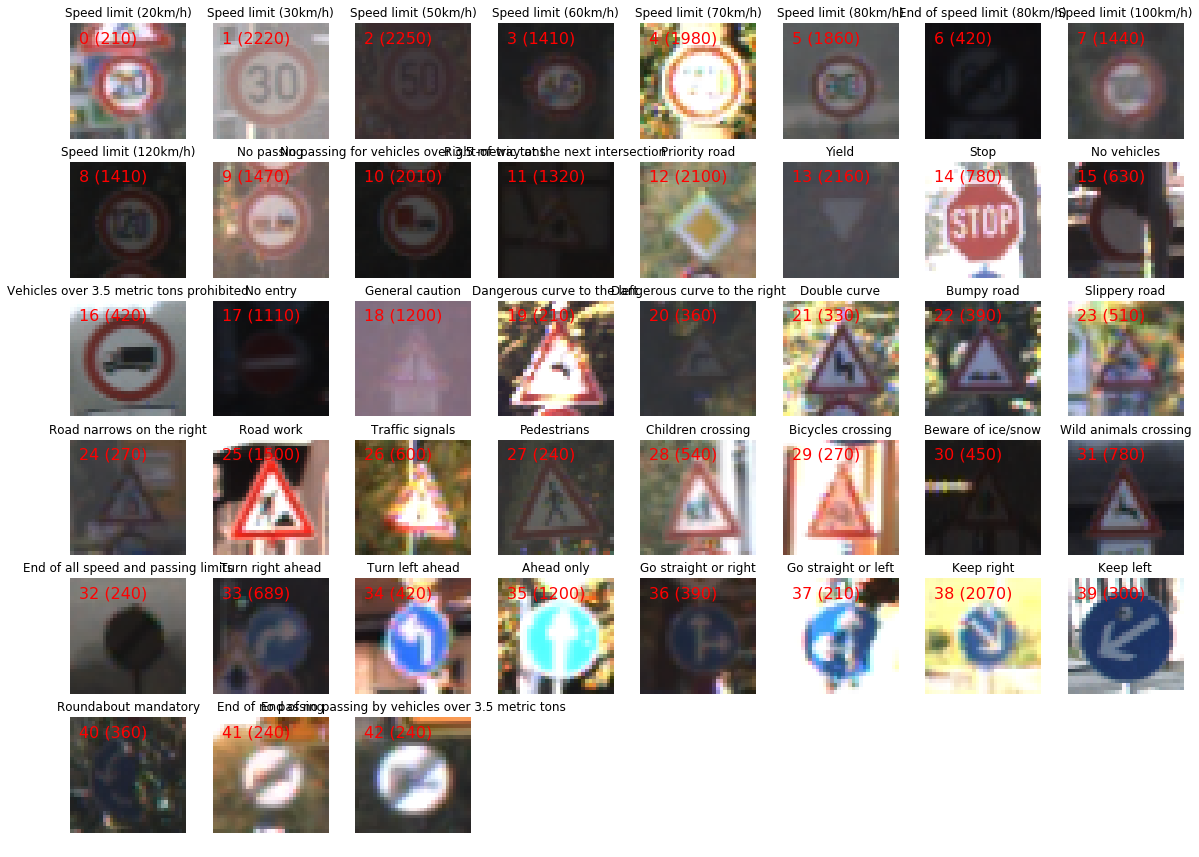

In [92]:
""" Data exploration visualization """

def visualize_data_per_sign(X, y):
    num_images_per_label = np.zeros(n_classes)    
    # Visualize data
    plt.figure(figsize=(20,20))
    for i in range(n_classes):
        item_index = np.argwhere(y == i)[0][0]
        if (item_index < 0): continue
        img = X[item_index]
        plt.subplot(8, 8, i + 1) # A grid of 8x8 columns
        plt.axis('off')
        count = (y == i).sum()
        plt.annotate('{} ({})'.format(i, count), xy=(2, 5), color='red', fontsize='16')
        plt.title(sign_labels[i])
        num_images_per_label[i] = count
        _ = plt.imshow(img)
    plt.show()
    
visualize_data_per_sign(X_train, y_train)

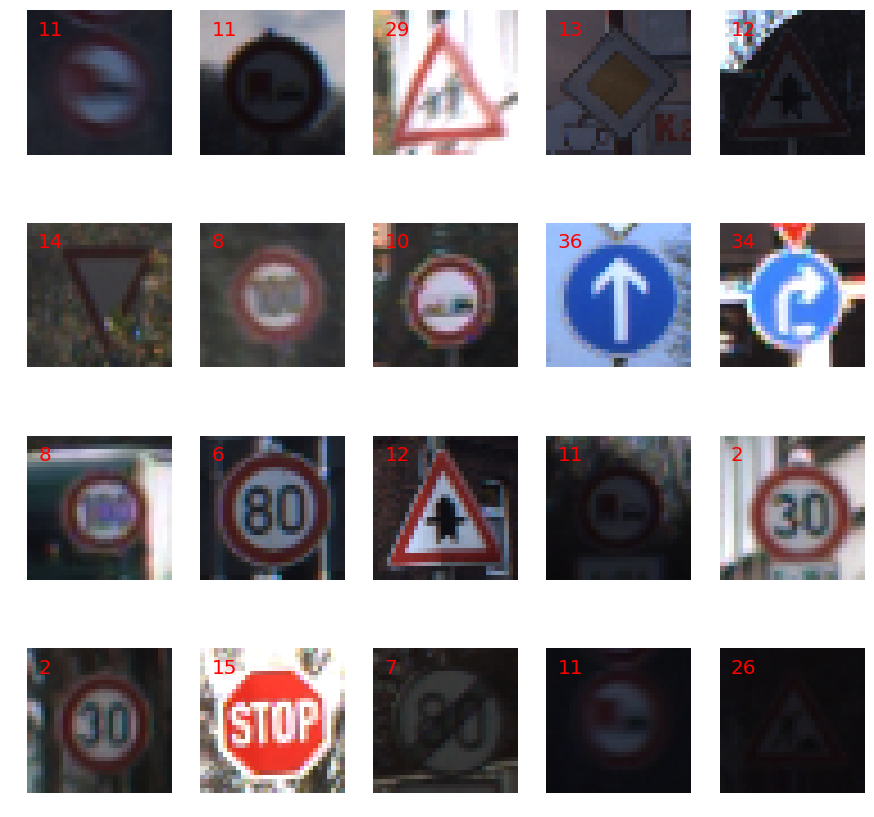

In [93]:
""" Data exploration visualization """

def explorer_random_images(num):
    rands = [random.randint(0, len(y_train)) for i in range(num)]
    _, ax = plt.subplots(num//5, 5, figsize=(15, 15))
    row, col = 0, 0
    for i in rands:
        img = X_train[i]
        ax[row, col].imshow(img)
        ax[row, col].annotate(int(y_train[i]) + 1, xy =(2, 5), color='red', fontsize='20')
        ax[row, col].axis('off')
        col += 1
        if col == 5: 
            row += 1
            col = 0
    plt.show()
explorer_random_images(20)

Histogram of randomly selected images from the sign 12  ......


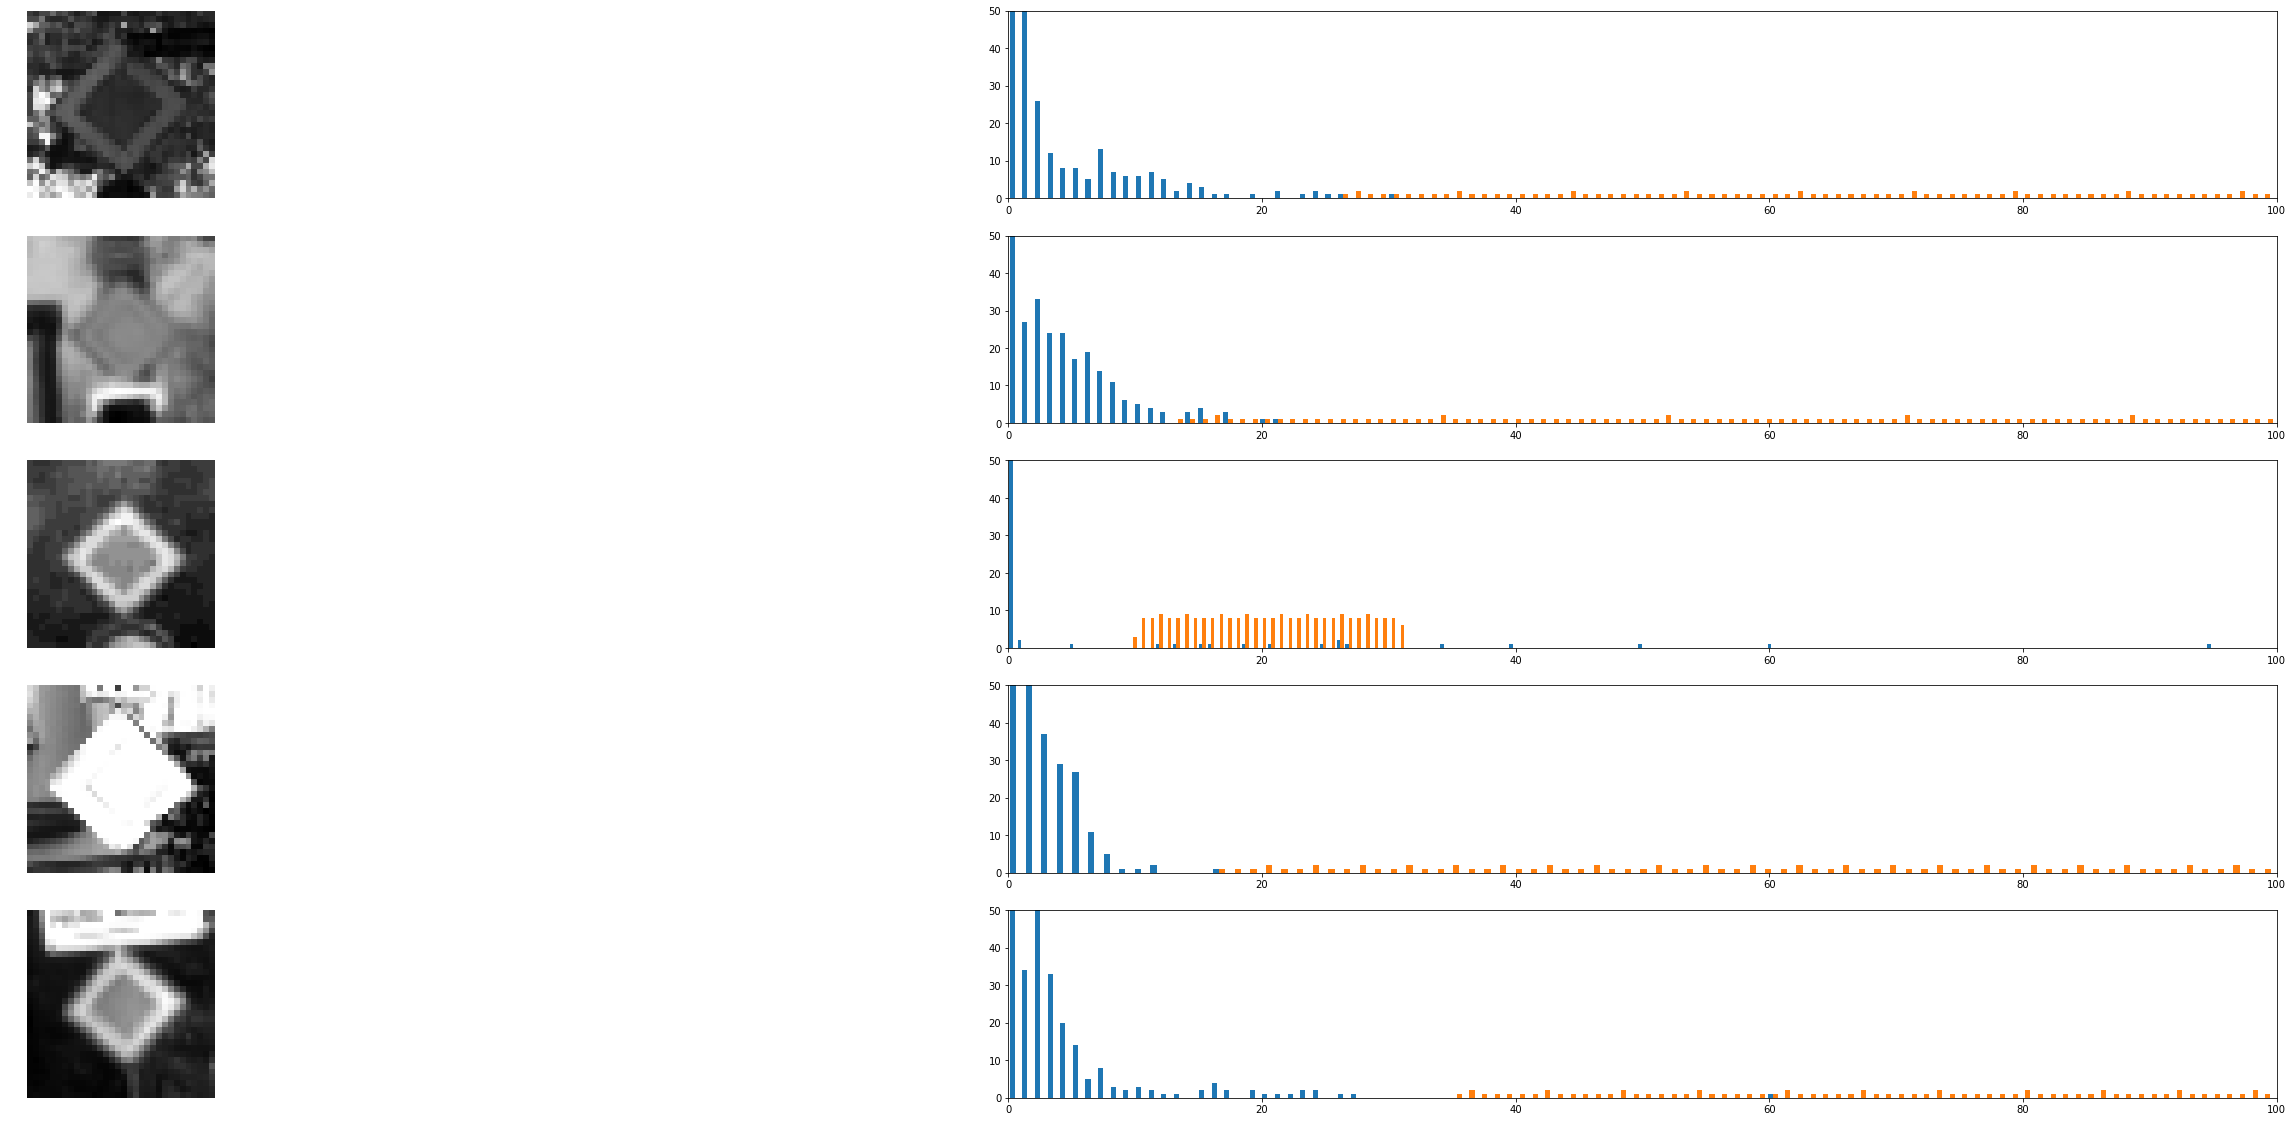

Histogram of randomly selected images from the sign 15  ......


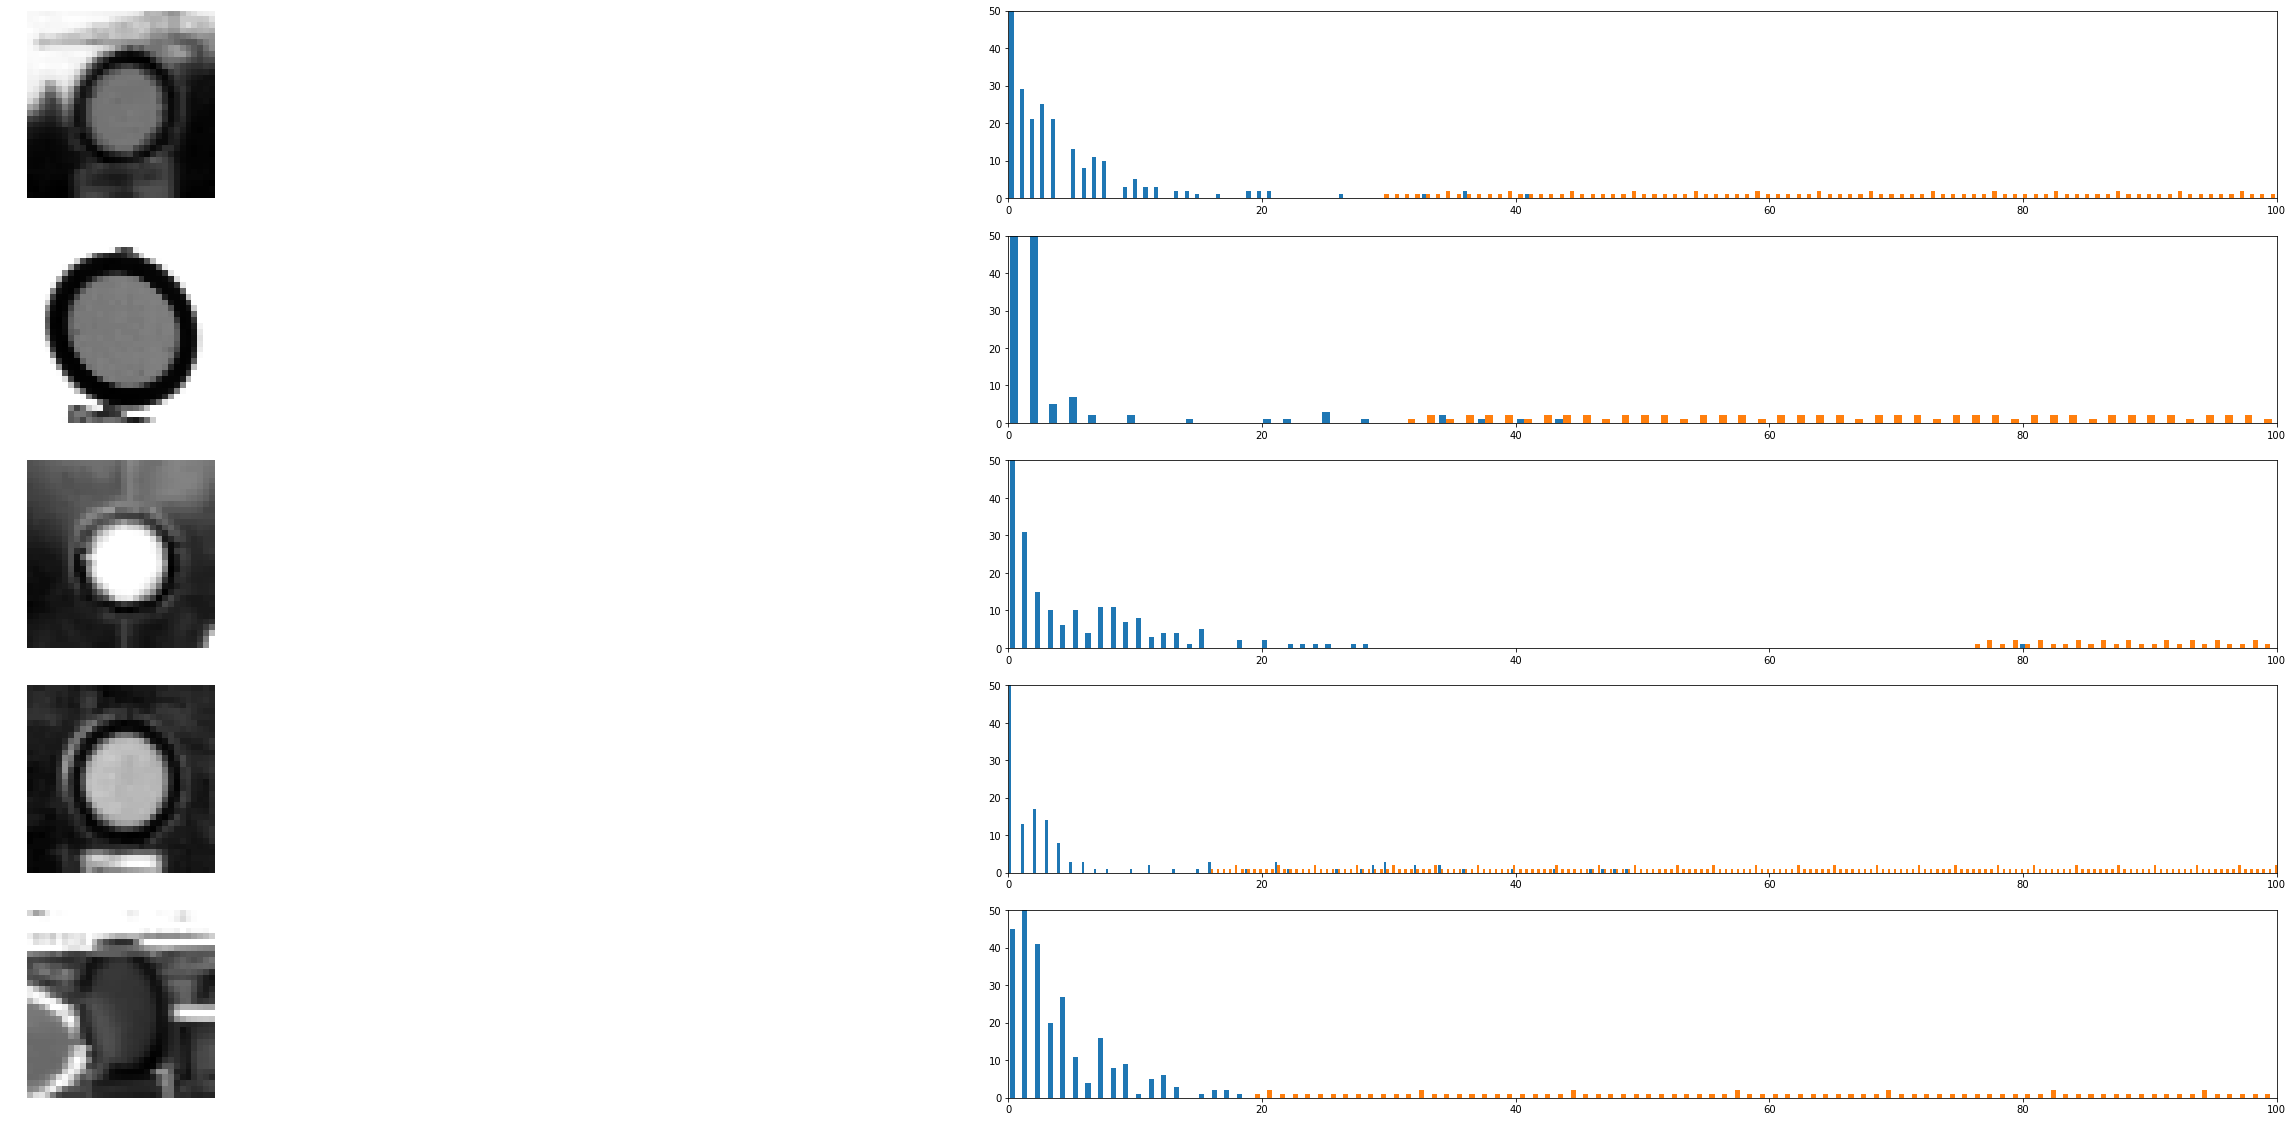

Histogram of randomly selected images from the sign 32  ......


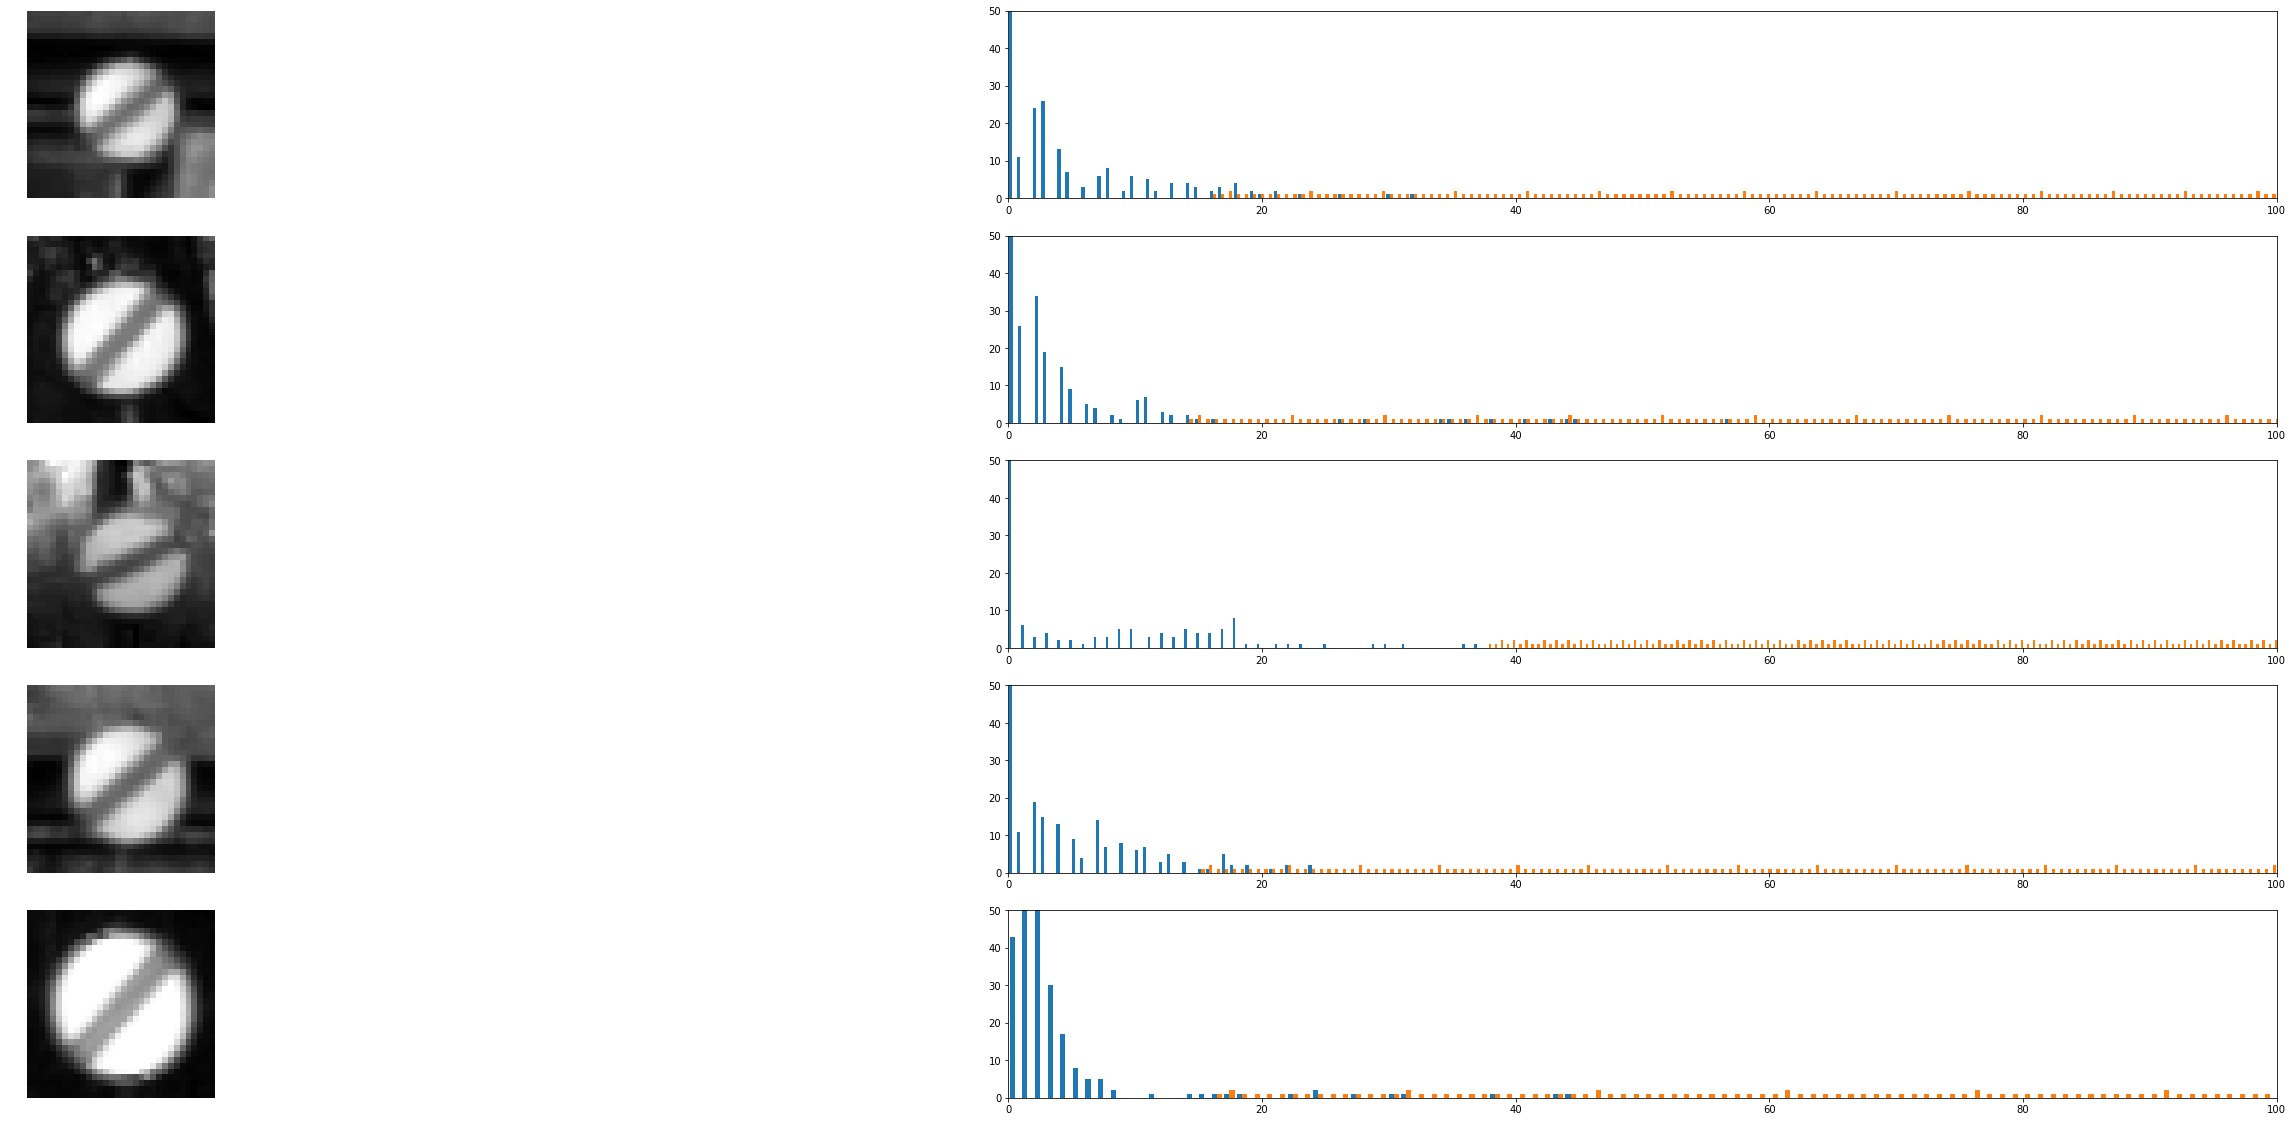

In [94]:
""" Data exploration visualization """

def histograms_random_images(label, channel=1, n_imgs=5, ylim=50):

    all_imgs = np.ravel( np.argwhere(y_train==label) )
    # pick 5 images randomly
    rand =  np.random.choice( all_imgs, size=n_imgs, replace=False)
    _, ax = plt.subplots( n_imgs, 2, figsize=(50,20))
    print('Histogram of randomly selected images from the sign {}  ......'.format(label))
    row, col = 0, 0  
    for i in rand:
        img = X_train[i, :, :, channel]
        #display image
        ax[row, col].imshow(img, cmap='gray')
        ax[row,col].axis('off')
        #display histogram
        hist = np.histogram(img, bins=256)
        ax[row, col + 1].hist(hist, bins=256)
        ax[row, col + 1].set_xlim([0, 100])
        ax[row, col + 1].set_ylim([0, ylim])
        #initialize col, row value
        col = 0
        row += 1
    plt.show()

histograms_random_images(12)
histograms_random_images(15)
histograms_random_images(32)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed

In [95]:
""" Pre-process data """
def preprocess_dataset(dataset):
    num_images = len(dataset)
    processed = np.zeros((num_images, IMG_HEIGHT, IMG_WIDTH, GRAY_IMG_DEPTH))
    for i in range(num_images):
        img = dataset[i]
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        processed[i,:,:,0] = gray_img/255. - 0.5
    return processed.reshape(-1, IMG_HEIGHT, IMG_WIDTH, GRAY_IMG_DEPTH)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I applied several preprocessing techniques with the goal of preparing data that is evenly and randomly distributed and normalized:

1. First step is to shuffle both the provided train data and test data to distribute data randomly. 
2. The second step is to split the provided train data set to training and validation set.
3. The train data set was not evenly distributed over different classes at all. For instance, "Speed limit (20km/h)" had fewer than 250 data while "Speed limit (30km/h)" had over 2,000 data. I applied the data augmentation for classes with fewer than 1,000 items by applying rotation and transpose.
4. I also noticed that the pixel intensity was not evenly distributed. To address the issue, each image was converted to a gray scale image, and pixel intensity has been adjusted to gray_img/255. - 0.5

In [96]:
""" Image Utils """
def get_random_image_rotation(img):
    rand_degree = random.randint(-10, 10)
    return rotate(img, rand_degree, reshape=False)

def geneate_random_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    rando = np.random.uniform(-0.50, 0.50)
    hsv[:,:, 2] = hsv[:,:, 2] * (1.0 + rando)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
def get_random_shadow_overlay(img):
    img_result = np.array(img)
    h, w = img_result.shape[0], img_result.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=False)
    k = h / (x2 - x1)
    b = -k * x1
    for i in range(h):
        c = int ((i - b) / k)
        img_result[i, :c, :] = (img_result[i, :c, :] * .5).astype(np.int32)
    return img_result

def jiggle_data(img):
    # Reference: https://medium.com/@ValipourMojtaba/my-approach-for-project-3-2545578a9319#.xzwtzhnaa
    
    # Transpose
    transRange = 10
    numPixels = 10
    transX = transRange * np.random.uniform() - transRange/2
    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1,0, transX], [0,1, transY]])
    img_result = cv2.warpAffine(img, transMat, (IMG_WIDTH, IMG_HEIGHT))
    
    # Shear
    shear_range = 10
    pts1 = np.float32([[0,0],[IMG_HEIGHT,0],[0,IMG_WIDTH]])

    pt1 = 0+shear_range*np.random.uniform()-shear_range/2
    pt2 = IMG_WIDTH+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,0],[pt2,pt1],[0,pt2]])

    shearMat = cv2.getAffineTransform(pts1,pts2)
    img_result = cv2.warpAffine(img_result, shearMat, (IMG_WIDTH, IMG_HEIGHT))    
    
    return img_result


def distort_image(img):
    if bool(random.getrandbits(1)): img = jiggle_data(img)
    #if bool(random.getrandbits(1)): img = geneate_random_brightness(img)
    if bool(random.getrandbits(1)): img = get_random_image_rotation(img)
    #if bool(random.getrandbits(1)): img = get_random_shadow_overlay(img)
    return img

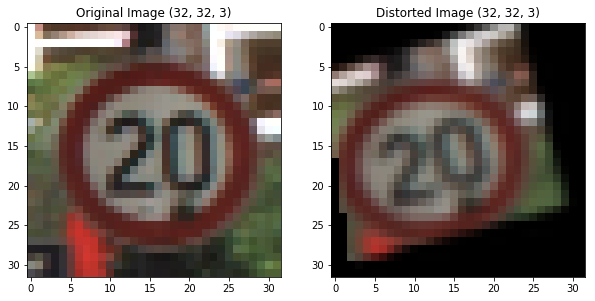

In [105]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.set_title('Original Image {}'.format(X_train[200].shape))
ax1.imshow(X_train[200])

distorted_img = distort_image(X_train[200])

ax2.set_title('Distorted Image {}'.format(distorted_img.shape))
ax2.imshow(distorted_img)

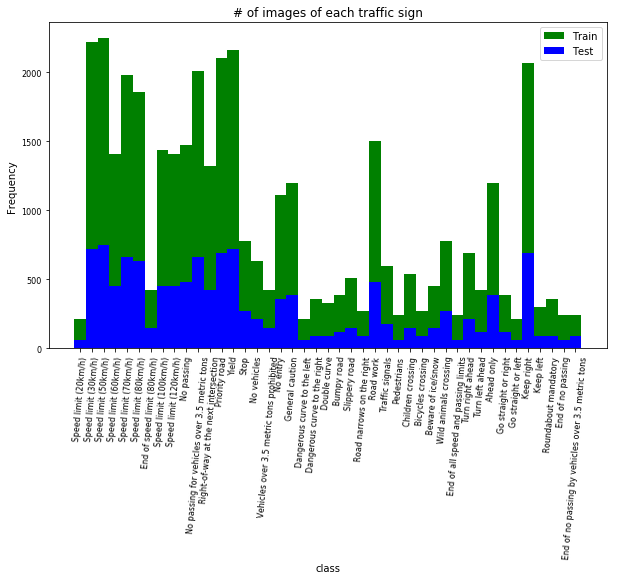

In [13]:
# Before Data Augmentation
def histograms_multiple_bars(title, y1, y2, y1_text, y2_text):

    num_images_per_y1 = np.zeros(n_classes)
    num_images_per_y2 = np.zeros(n_classes)
    
    for label in set(y1):
        num_images_per_y1[label] = (y1 == label).sum()
    for label in set(y2):
        num_images_per_y2[label] = (y2 == label).sum()
    
    # Histogram
    hist_fig = plt.figure(figsize=(10, 6))    
    ax = hist_fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=8)
    
    p1 = ax.bar(np.arange(len(sign_labels)), num_images_per_y1, width=1, color='g')
    p2 = ax.bar(np.arange(len(sign_labels)), num_images_per_y2, width=1, color='b')
    ax.set_xlabel('class')
    ax.set_ylabel('Frequency')
    ax.set_xticks(np.arange(len(sign_labels)))
    ax.set_xticklabels(sign_labels, rotation=85)
    ax.set_title(title)
    
    ax.legend((p1, p2), (y1_text, y2_text))

    plt.show()    
    
histograms_multiple_bars('# of images of each traffic sign', y_train, y_test, 'Train', 'Test')

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

- I augmented data by adding randomly rotated images, images with random brightness and images with random shadows.
- I split the augmented data to 80% training data and 20% validation data.

In [47]:
# Shuffle data
X_shuffle, y_shuffle = shuffle(X_train, y_train)

# Split data to train and validation set
train_features, validation_features, train_labels, validation_lables = train_test_split(X_shuffle, y_shuffle, test_size=0.2, random_state=0)
print('training data set: {}'.format(train_features.shape))
print('validation data set: {}'.format(validation_features.shape))

training data set: (31367, 32, 32, 3)
validation data set: (7842, 32, 32, 3)


### Before Data Augmentation - Train vs. Validation
The graph below shows that the train data is not evenly distributed over classes.

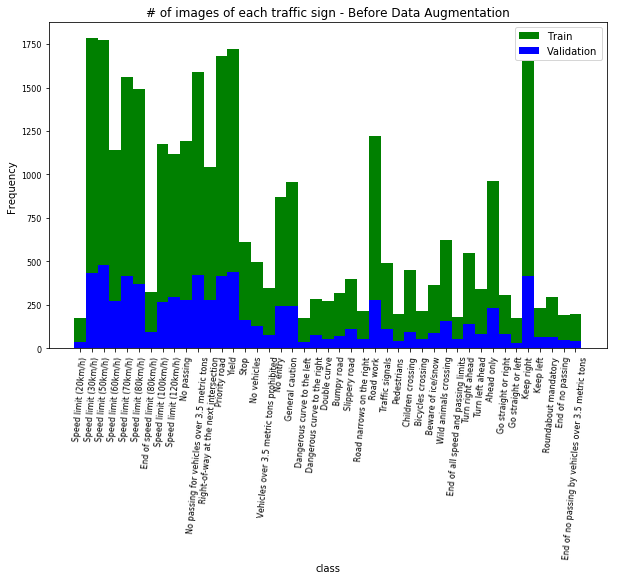

In [48]:
histograms_multiple_bars('# of images of each traffic sign - Before Data Augmentation', train_labels, validation_lables, 'Train', 'Validation')

In [49]:
""" Data Augmentation"""
def bulk_distort_images(category, y, batch_size):
    X_result = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.uint8)
    y_result = np.zeros((batch_size), dtype=np.int)
    n_items = len(y)
    for i in range(batch_size):
        idx = i % n_items
        src_img = train_features[y[idx][0]]
        X_result[i] = distort_image(src_img)
        y_result[i] = category
    return X_result, y_result

def augument_train_dataset():

    max_num = 0
    num_images_per_y = np.zeros(n_classes, dtype=np.int)
    for i in train_labels:
        num_images_per_y[i] += 1 
        max_num = max(max_num, num_images_per_y[i])
    
    target_num = 1000 #int(max_num * 1)
    X_generated = np.concatenate([train_features])
    y_generated = np.concatenate([train_labels])
    
    for i in range(n_classes):
        y_items = np.argwhere(train_labels == i)
        y_items_count = len(y_items)
        diff = target_num - y_items_count
        if diff > 0:
            X_dist, y_dist = bulk_distort_images(i, y_items, diff)
            X_generated = np.concatenate([X_generated, X_dist])
            y_generated = np.concatenate([y_generated, y_dist])
    
    return X_generated, y_generated

### After Data Augmentation - Train vs. Validation
The graph below shows that majority of train data evenly distributed over classes.

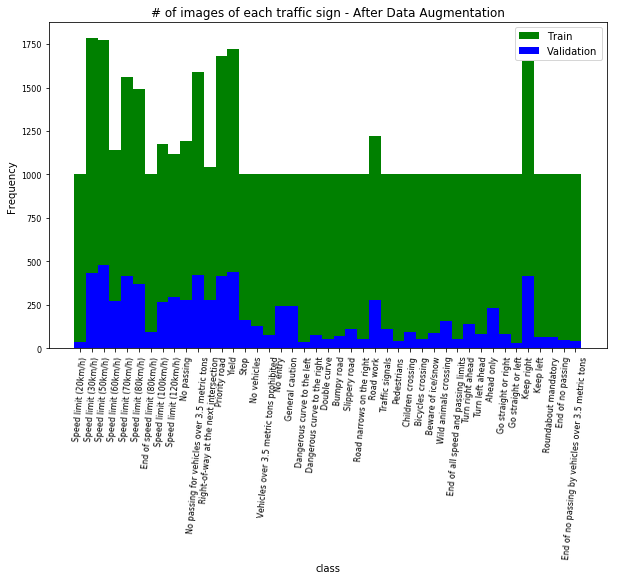

In [106]:
X_augmented, y_augmented = augument_train_dataset()
histograms_multiple_bars('# of images of each traffic sign - After Data Augmentation', y_augmented, validation_lables, 'Train', 'Validation')

In [51]:
print(len(train_features), len(X_augmented), len(y_augmented))

31367 49141 49141


Histogram of randomly selected images from the sign 2  ......


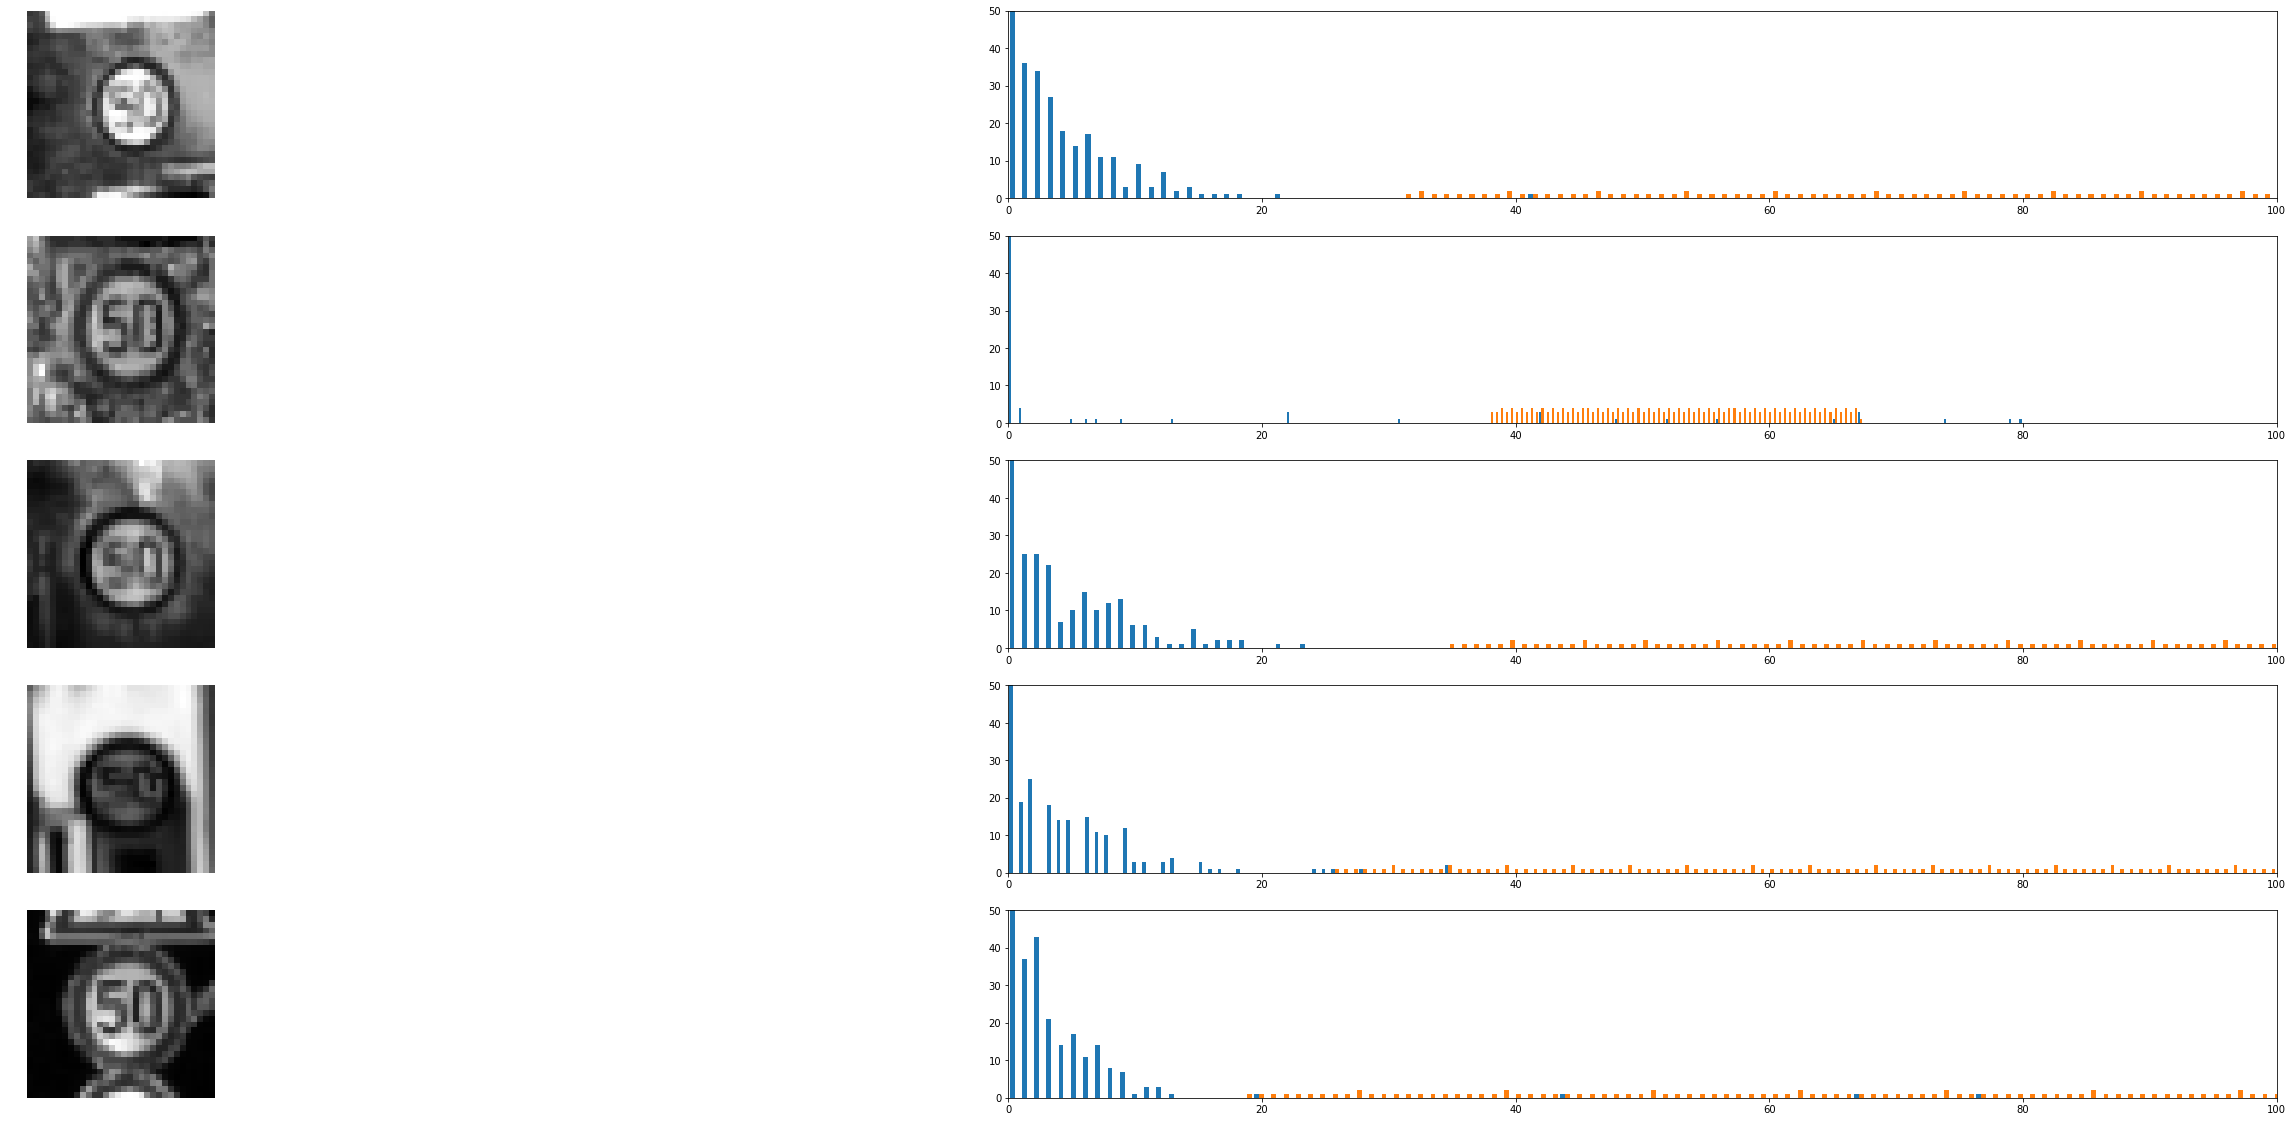

In [52]:
histograms_random_images(2)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final architecture is a CNN with three convolutional layers and three fully connected layers. Additionally, I added dropout to hidden layers and maxpooling in the convlutional layers. The input is a gray scale image (32x32 image with 1 color channel).

Here are details:

**Input:**
- 32x32x1 image

**Convolutional layer 1:**
- 80 kernels of 3x3 size.
- ReLU
- Dropout
- Output: 30x30x80

**Convolutional layer 2:**
- 120 kernels of 3x3 size.
- ReLU
- Output: 30x30x120
- Dropout
- Max pooling - Output: 15x15x120

**Convolutional layer 3:**
- 180 kernels of 4x4 size.
- ReLU
- Output: 15x15x120
- Max pooling - Output: 15x15x120
- Dropout
- Flatten - Output: 720

**Fully connected layer 1:**
- ReLU
- Dropout
- Output: 80 units

**Fully connected layer 2:**
- ReLU
- Dropout
- Output: 80 units

**Output layer:**
- Output: 80 units

In [53]:
## Model architecture and hyperparameters
tf.reset_default_graph()

learning_rate = 0.001
keep_probability = 0.5
mu = 0
sigma = 0.05
beta = 0.0001

with tf.name_scope('weights'):
    weights = {
        'conv1':tf.Variable(tf.truncated_normal([3, 3, GRAY_IMG_DEPTH, 80], mean=mu, stddev=sigma, name='weight_conv1')),
        'conv2':tf.Variable(tf.truncated_normal([3, 3, 80, 120], mean=mu, stddev=sigma, name='weight_conv2')),
        'conv3':tf.Variable(tf.truncated_normal([4, 4, 120, 180], mean=mu, stddev=sigma, name='weight_conv3')),
        'fc1':tf.Variable(tf.truncated_normal([720, 80], mean=mu, stddev=sigma, name='weight_fc1')),
        'fc2':tf.Variable(tf.truncated_normal([80, 80], mean=mu, stddev=sigma, name='weight_fc2')),
        'out':tf.Variable(tf.truncated_normal([80, n_classes], mean=mu, stddev=sigma, name='weight_out')) 
    }
    
with tf.name_scope('biases'):
    biases = {
        'conv1':tf.Variable(tf.zeros(80), name='bias_conv1'),
        'conv2':tf.Variable(tf.zeros(120), name='bias_conv2'),
        'conv3':tf.Variable(tf.zeros(180), name='bias_conv3'),
        'fc1':tf.Variable(tf.zeros(80), name='bias_fc1'),
        'fc2':tf.Variable(tf.zeros(80), name='bias_fc2'),
        'out':tf.Variable(tf.zeros(n_classes), name='bias_out')
    }
    
def conv_net(x):
    with tf.name_scope('conv1'):
        conv1 = tf.nn.conv2d(x, weights['conv1'], [1,1,1,1], 'VALID', name='conv1_op')
        conv1 = tf.nn.bias_add(conv1, biases['conv1'])
        print('conv1', conv1.get_shape())  
        conv1 = tf.nn.relu(conv1, name='conv1_act')
        
        conv1 = tf.nn.max_pool(conv1, [1,2,2,1],[1,2,2,1],'VALID')
        conv1 = tf.nn.dropout(conv1, keep_prob, name='conv1_drop')
        
    with tf.name_scope('conv2'):
        conv2 = tf.nn.conv2d(conv1, weights['conv2'], [1,1,1,1], 'SAME', name='conv2_op')
        conv2 = tf.nn.bias_add(conv2, biases['conv2'])
        print('conv2', conv2.get_shape())  
        conv2 = tf.nn.relu(conv2)
        
        conv2 = tf.nn.max_pool(conv2, [1,2,2,1],[1,2,2,1],'VALID')
        conv2 = tf.nn.dropout(conv2, keep_prob, name='conv2_drop')
        
    with tf.name_scope('conv3'):
        conv3 = tf.nn.conv2d(conv2, weights['conv3'], [1,1,1,1], 'VALID', name='conv3_op')
        conv3 = tf.nn.bias_add(conv3, biases['conv3'])
        print('conv3', conv3.get_shape())  
        conv3 = tf.nn.relu(conv3)
        
        conv3 = tf.nn.max_pool(conv3, [1,2,2,1],[1,2,2,1],'VALID')
        conv3 = tf.nn.dropout(conv3, keep_prob, name='conv3_drop')        
        print('conv3', conv3.get_shape())  
        
        fc0 = tf.contrib.layers.flatten(conv3)
        print('fc0', fc0.get_shape())        
        
    with tf.name_scope('fc1'):
        fc1 = tf.add(tf.matmul(fc0, weights['fc1']), biases['fc1'], name='fc1_op')
        
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, keep_prob)
        
    with tf.name_scope('fc2'):
        fc2 = tf.add(tf.matmul(fc1, weights['fc2']), biases['fc2'], name='fc2_op')
        fc2 = tf.nn.relu(fc2)
        fc2 = tf.nn.dropout(fc2, keep_prob)
        
    with tf.name_scope('logits'):
        logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'], name='logits')
        
    return logits
    
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, (None, IMG_HEIGHT, IMG_WIDTH, GRAY_IMG_DEPTH), name='x')
    y = tf.placeholder(tf.int32, (None), name='y')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    one_hot_y = tf.one_hot(y, n_classes)    

logits = conv_net(x)

with tf.name_scope('regularizer'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_regularizer = beta * (tf.nn.l2_loss(weights['fc1']) \
                               + tf.nn.l2_loss(weights['fc2']) + tf.nn.l2_loss(weights['out']))

with tf.name_scope('loss_operation'):
    loss_operation = tf.reduce_mean(cross_entropy) + loss_regularizer
    train_operation = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_operation)
    
with tf.name_scope('prediction'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
print('logits: ', logits)

conv1 (?, 30, 30, 80)
conv2 (?, 15, 15, 120)
conv3 (?, 4, 4, 180)
conv3 (?, 2, 2, 180)
fc0 (?, 720)
logits:  Tensor("logits/logits:0", shape=(?, 43), dtype=float32)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The AdamOptimizer was used as it worked well. I chose the batch size to be 200 as 200 and above worked well. Below 200, the loss was too noisy. 

For my last test, I achieve 99.80% accuracy with the following parameters:

- **batch size: 200**
- **learning rate: 0.001** 
- **EPOCHS: 150**
- **keep_probability: 0.5**
- **beta: 0.01**

In [54]:
### Train your model here.
### Feel free to use as many code cells as needed.


### Training

In [55]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    session = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x = X_data[offset:end]
        batch_y = y_data[offset:end]
        accuracy, loss = session.run([accuracy_operation, loss_operation], \
                                    feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += accuracy * len(batch_x)
        total_loss += loss * len(batch_x)
    return [total_accuracy / num_examples, total_loss / num_examples]

In [56]:
def visualize_learning_curves(training_losses, training_accuracies, dev_losses, dev_accuracies):
    epochs = np.arange(len(training_losses))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, training_losses, color='g', linewidth=2.0, label='training')
    plt.plot(epochs, dev_losses, color='m', linewidth=2.0, label='validation')

    plt.ylabel('loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, training_accuracies, color='g', linewidth=2.0, label='training')
    plt.plot(epochs, dev_accuracies, color='m', linewidth=2.0, label='validation')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()

    plt.show()

In [57]:
# Shuffle data
X_augmented, y_augmented = shuffle(X_augmented, y_augmented)

42109


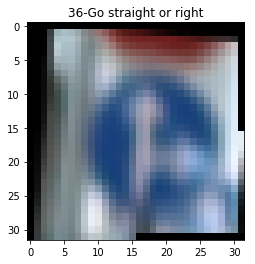

In [71]:
rand_idx = random.randint(0, len(y_augmented))
plt.imshow(X_augmented[rand_idx])
plt.title('{}-{}'.format(y_augmented[rand_idx], sign_labels[y_augmented[rand_idx]]))
print(rand_idx)

# y_items = np.argwhere(train_labels == 33)
# print(y_items)

# plt.imshow()

Training ...
Pre-processing train data
End Pre-processing train data


-------------------------------------------------------------------
Epoch	Train accuracy	Valid. accuracy	Train loss	Valid. loss
-------------------------------------------------------------------
1	0.0593		0.0925		3.62099		3.55661
2	0.3864		0.4647		2.11187		1.87972
3	0.5724		0.6450		1.35534		1.13560
4	0.6842		0.7584		1.05722		0.85505
5	0.7549		0.8203		0.79396		0.60889
6	0.8153		0.8562		0.63870		0.48838
7	0.8669		0.9027		0.50561		0.37990
8	0.8874		0.9079		0.42859		0.32203
9	0.9111		0.9328		0.37469		0.27677
10	0.9288		0.9447		0.32366		0.24358
11	0.9409		0.9561		0.27744		0.20883
12	0.9418		0.9523		0.26302		0.20024
13	0.9555		0.9625		0.22203		0.17087
14	0.9609		0.9647		0.19930		0.15635
15	0.9644		0.9705		0.18500		0.14138
16	0.9663		0.9718		0.17164		0.13385
17	0.9652		0.9744		0.16832		0.12863
18	0.9749		0.9768		0.15020		0.11861
19	0.9783		0.9806		0.14092		0.11326
20	0.9817		0.9829		0.12847		0.10520
21	0.9827		0.9847		0.1

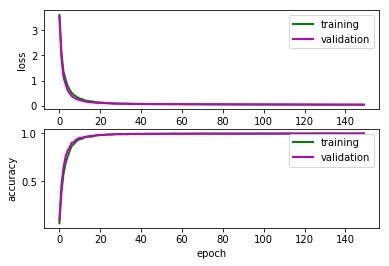



Session saved




In [72]:
EPOCHS = 150
BATCH_SIZE = 200

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    num_examples = len(X_augmented)
    print('Training ...')
    train_summary = []
    
    print('Pre-processing train data')
    train_prep = preprocess_dataset(X_augmented)
    validation_prep = preprocess_dataset(validation_features)
    print('End Pre-processing train data')
    print('\n\n-------------------------------------------------------------------')
    print('Epoch\tTrain accuracy\tValid. accuracy\tTrain loss\tValid. loss')
    print('-------------------------------------------------------------------')
    
    train_accuracies = []
    valid_accuracies = []

    train_losses = []
    valid_losses = []
    
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x = train_prep[offset:end]
            batch_y = y_augmented[offset:end]
            session.run(train_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:keep_probability})
        train_accuracy, train_loss = evaluate(train_prep, y_augmented)
        valid_accuracy, valid_loss = evaluate(validation_prep, validation_lables)
        print('{}\t{:.4f}\t\t{:.4f}\t\t{:.5f}\t\t{:.5f}'.format(i + 1, train_accuracy, valid_accuracy, train_loss, valid_loss))
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        valid_accuracies.append(valid_accuracy)
        valid_losses.append(valid_loss)
        
    print('End Training ...')
    
    visualize_learning_curves(train_losses, train_accuracies, valid_losses, valid_accuracies)

    try:
       saver
    except NameError:
       saver = tf.train.Saver()
    saver.save(session, './conv_net')
    print('\n\nSession saved\n\n')

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with a rudimentary prototype with a single convolutionary layer to test the end-to-end pipeline from preprocessing training data to train and evaluate the training accuracy. This resulted in the accuracy of 99.96%.

Since this project is a well-known problem of predicting images based on deep learning, I chose the CNN, and I upgraded the model to have 3 convolutional layers and fully connected layers.

Once I had a working CNN model, I started to augment data by applying different techniques. Because it was timeconsuming to train the model, I usually kept the epoch to be as low as 10, and verified that the train accuracy and loss are improving. Once I verified that the loss is converging to zero over epochs, I increased the epoch to 200, and let the actual training to complete.

**Accuracy:**
- Training set: 99.96%%
- Validation set: 99.87%
- Test set: 97.93%.

### Measuring Accuracy Against The Test Data Set

In [74]:
saver = tf.train.Saver()

test_prep = preprocess_dataset(X_test)

with tf.Session() as session:
    saver.restore(session, './conv_net')
    
    test_accuracy, test_loss = evaluate(test_prep, y_test)
    
    print('Test accuracy: {:.4f}'.format(test_accuracy))

Test accuracy: 0.9793


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I collected road photos that contain traffic signs, and cropped the traffic signs to collect real traffic sign images as shown below:
- The first image ("Speed limit (50km/h)") has shadow on the right half, potentially making it difficult to predict correctly.
- The second image ("Speed limit (50km/h)") is slightly tilted, potentially making it difficult to predict correctly.
- The third, fourt and fith are all "Stop" signs with different conditions. The fifth one has reflection, which may make it difficult to predict correctly.
- The sixth, seventh and eighth images are for "No entry." The seventh one is especially tricky as it has light bulbs surrounding the circumference.

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

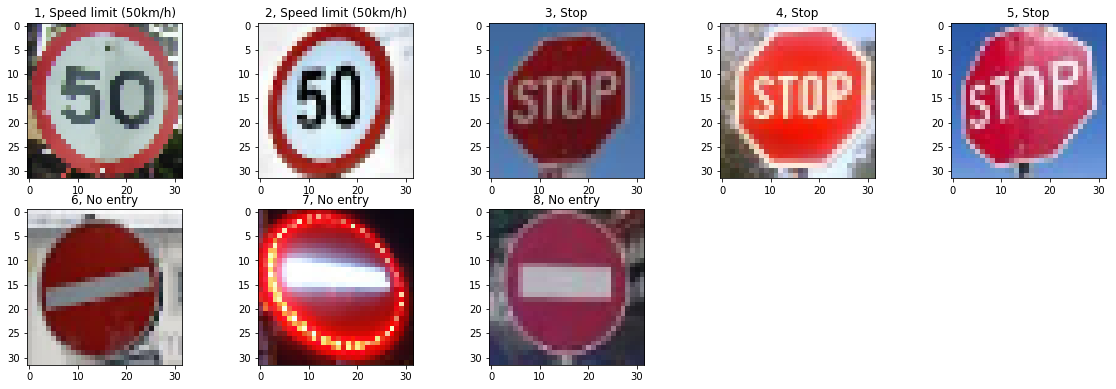

In [76]:
real_images = []
    
for path in sorted(listdir('test_images')):
    img = cv2.imread('%s%s' % ('test_images/', path))
    img = cv2.resize(img, (32, 32))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    real_images.append(img)
real_labels = np.array([2, 2, 14, 14, 14, 17, 17, 17], dtype=np.uint8)
    
plt.figure(figsize=(20,20))
for i, img in enumerate(real_images):
    sub = plt.subplot(6,5,i+1)
    plt.imshow(real_images[i])
    sub.set_title("%s, %s" % (i + 1, sign_labels[real_labels[i]]))  

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The short answer was no. Based on the real images, the model predicted 7 out of 8 signs correctly, achieving **87.50%** accuracy for the newly captured images. This is far lower than the test accuracy of 97.93%.

As I worried in Question 6, the model falsly recognized a "Speed limit (50km/h)" as a different sign. I suspect that it is because of the shadow that covered the right half of the sign.

In [80]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

In [81]:
""" Evaluate the real data """
real_prep = preprocess_dataset(real_images)
saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, './conv_net')
    test_accuracy, train_loss = evaluate(real_prep, real_labels)

    print('Accuracy with real signs: {:.4f}'.format(test_accuracy))

Accuracy with real signs: 0.8750


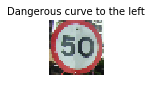

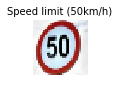

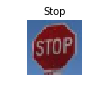

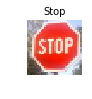

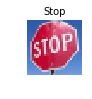

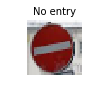

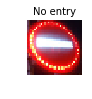

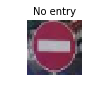

In [82]:
saver = tf.train.Saver()

softmax = tf.nn.softmax(logits)

with tf.Session() as session:
    saver.restore(session, './conv_net')
    
    predict_prob = session.run(softmax, feed_dict={x: real_prep, keep_prob: 1})
    prediction_real_images = np.argmax(predict_prob, 1)
    
for i in range(len(real_prep)):
    plt.figure(figsize=(1,1))
    plt.imshow(real_images[i])
    plt.title(sign_labels[prediction_real_images[i]], fontsize=10)
    plt.axis('off')
    plt.show()    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

As shown on the result below, the model predicted 7 out 8 correctly for the traffic sign images that I captured from real road photos. The model was certain of "Stop" signs and "No entry" signs as shown on the char below. The model was not certain of "Speed limit (50km/h)." In one of the "Speed limit (50km/h)," the model did not correctly predict the "Speed limit (50km/h)" sign as a first guess even though it predicted as a second guess.

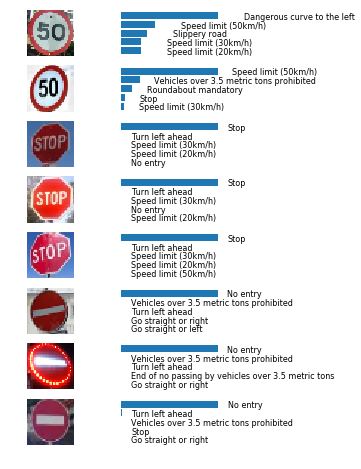

In [84]:
saver = tf.train.Saver()

softmax = tf.nn.softmax(logits)

top_k = 5

with tf.Session() as session:
    saver.restore(session, './conv_net')
    topk_values = tf.nn.top_k(softmax, top_k)
    topk_prob = session.run([softmax, topk_values], feed_dict={x: real_prep, keep_prob: 1})


_, arr = plt.subplots( len(real_images), 2, figsize=(4,8))
j = 0
for i in range(len(real_images)):
    arr[i, j].imshow(real_images[i])
    arr[i,j].axis('off')
    j += 1
    arr[i, j].barh(-np.arange(top_k),topk_prob[1][0][i], align='center')
    
    #annotations
    for k in range(top_k):
        text_pos = [topk_prob[1][0][i][k]+.1, -(k+0.4) ]
        arr[i, j].text( text_pos[0], text_pos[1], sign_labels[topk_prob[1][1][i][k]], fontsize=8)
    arr[i, j].axis('off')
    j = 0
plt.show()
    


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.